<a href="https://colab.research.google.com/github/yoonju977/CV_hufs_25-1/blob/main/CV_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/HUFS/컴퓨터비전"
weights_path = f"{base_path}/yolov3.weights"
config_path = f"{base_path}/yolov3.cfg"
names_path = f"{base_path}/coco_names.txt"
image_paths = [
    f"{base_path}/soccer.jpg",
    f"{base_path}/busy_street.jpg",
    f"{base_path}/car_people.jpeg"
]

In [3]:
!pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt


with open(names_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]


net = cv2.dnn.readNet(weights_path, config_path)


net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [6]:
def detect_objects(image_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]

    #blob 생성
    blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    #출력 레이어 이름 가져오기
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except IndexError:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * [width, height, width, height]).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    #NMS 적용
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)


    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.rectangle(img, (x, y), (x + w, y + h), (0,255,0), 2)
        cv2.putText(img, label, (x, y - 10), font, 0.5, (0,255,0), 1)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



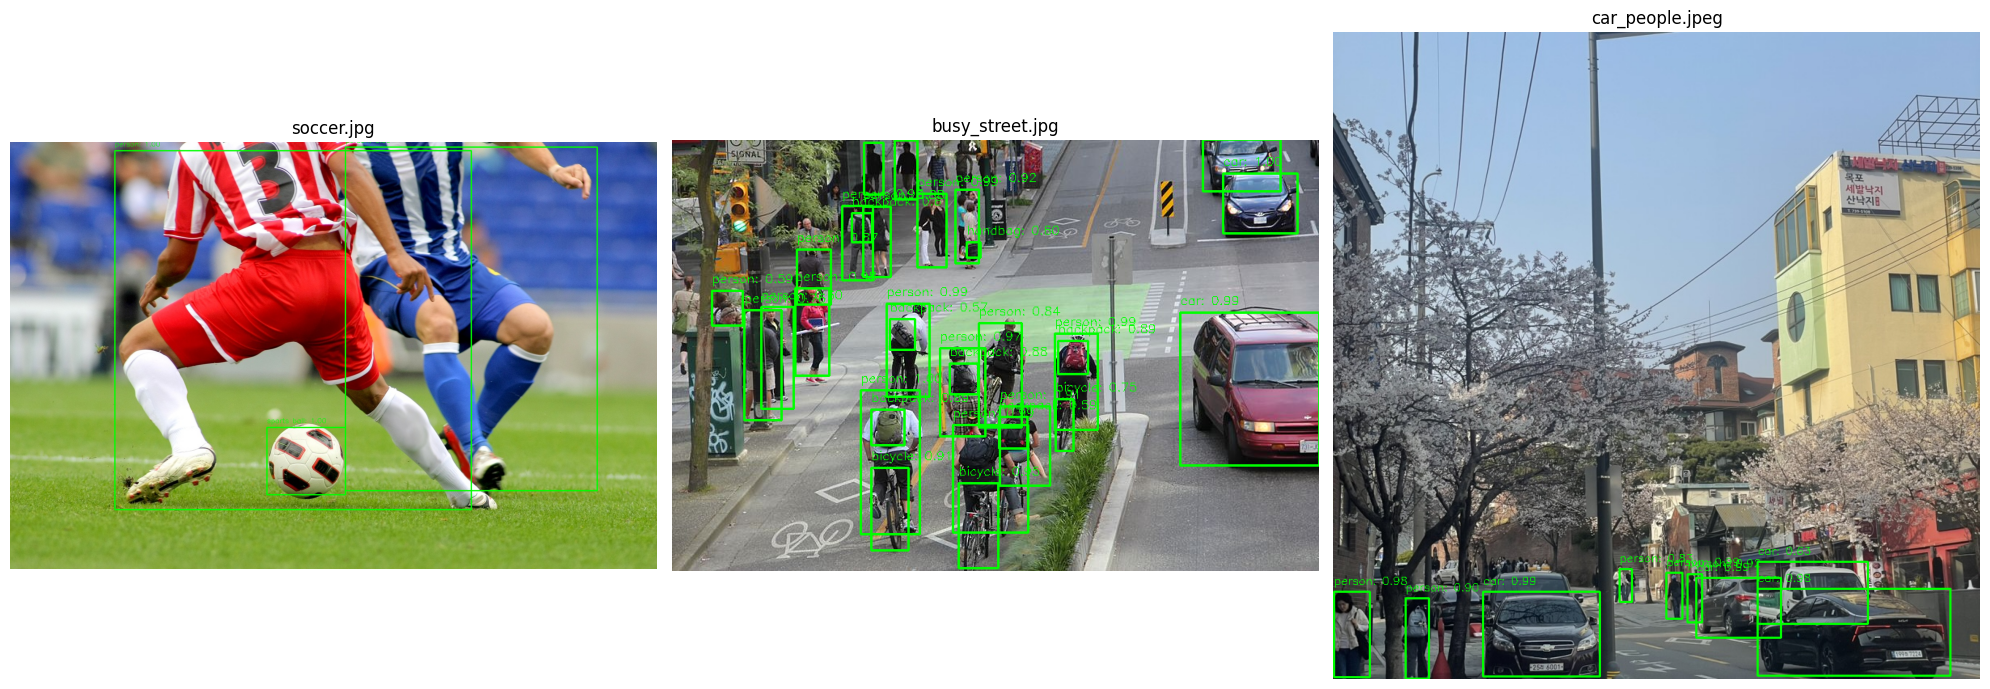

In [7]:
#결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
titles = ["soccer.jpg", "busy_street.jpg", "car_people.jpeg"]

for i, path in enumerate(image_paths):
    result = detect_objects(path)
    axes[i].imshow(result)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

#2. YOLO 작동방식

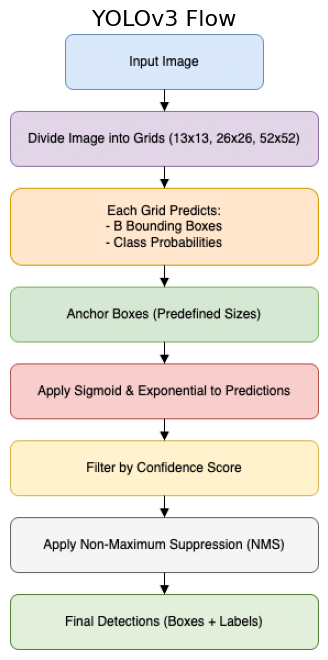

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 경로
img_path = "/content/drive/MyDrive/HUFS/컴퓨터비전/yolo3.drawio.png"

# 이미지 출력
img = mpimg.imread(img_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.title("YOLOv3 Flow", fontsize=16)
plt.show()

1. 416x416 등 정사각형 크기로 리사이즈된 이미지를 입력 -> 이미지 그리드 분할 진행
2. 이미지가 13*13, 26*26, 52*52 크기의 여러 셀로 분할
3. 각 그리드 셀에서 여러 개의 앵커 박스를 기반으로 예측 -> 각 예측은 [x, y, w, h, objectness, class_probabilities]로 구성
4. 시그모이드 함수와 exponential 함수를 사용하여 좌표와 크기 보정이 수행
5. confidence score가 임계값보다 높은 경우만 유지되게끔 필터링
6. NMS(Non-Maximum Suppression)를 적용해 중복된 박스를 제거
7. 최종적으로 물체 클래스 및 위치 박스가 표시된 결과 출력